<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорты-модулей-и-общие-функции" data-toc-modified-id="Импорты-модулей-и-общие-функции-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорты модулей и общие функции</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Ресемплирование-(1-час)" data-toc-modified-id="Ресемплирование-(1-час)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Ресемплирование (1 час)</a></span></li><li><span><a href="#Скользящее-среднее-(размер-окна-24)" data-toc-modified-id="Скользящее-среднее-(размер-окна-24)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Скользящее среднее (размер окна 24)</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#Стационарные-ряды" data-toc-modified-id="Стационарные-ряды-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Стационарные ряды</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных-для-обучения,-разделение-на-выборки" data-toc-modified-id="Подготовка-данных-для-обучения,-разделение-на-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных для обучения, разделение на выборки</a></span></li><li><span><a href="#Масштабирование-признаков" data-toc-modified-id="Масштабирование-признаков-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Масштабирование признаков</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импорты модулей и общие функции

In [1]:
!pip install --upgrade pip -q
!pip install -U scikit-learn -q

from lightgbm import LGBMRegressor
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
def view_and_get_data(path, sep=None, decimal=","):
    """
    Открывает файл, выводит первые 10 строк,
    основную информцию о дата фрейме и возвращает датафрейм.
    Принимает разделить в csv файле и разделитель десятичных чисел(по умолчанию запятая).
    """
    try:
        # Пробуем открыть файл локально, если нет, то через сервер яндекса.
        data = pd.read_csv(path, sep=sep, decimal=decimal, engine='python', index_col=[0], parse_dates=[0])
    except Exception:
        print('Локальный файл не найден. Пробую открыть серверную версию файла.')
        data = pd.read_csv(f'https://ссылки_под_запретом{path}', sep=sep, decimal=decimal, index_col=[0], parse_dates=[0])
        
    display(data.head(10))
    data.info()
    data.sort_index(inplace=True)
    return data

In [3]:
# Задаем параметры отображения для графиков
rcParams['figure.figsize'] = 12,8

In [4]:
data_taxi = view_and_get_data('/datasets/taxi.csv')

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Вывод:**    
    В дата фрейме пордяка 26,5 тыс.строк, а так же данные за период с 01.03.2018 по 31.08.2018, то есть данные за полгода.

## Анализ

Построим график временного ряда.

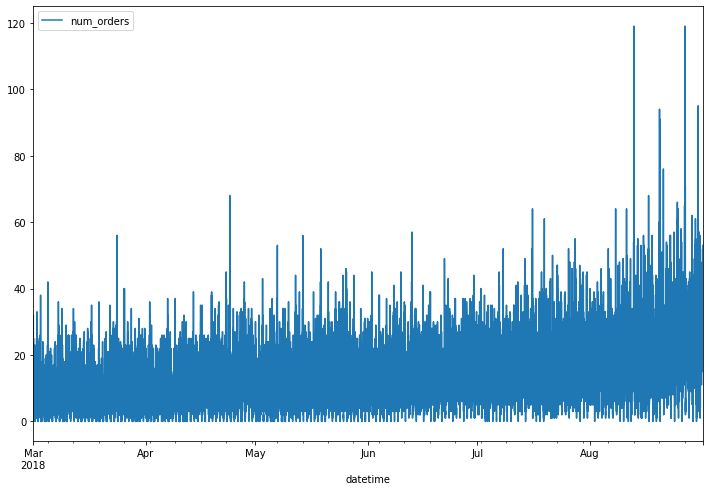

In [5]:
data_taxi.plot();

### Ресемплирование (1 час)

Выполним ресемплирование по одному часу согласно заданию.

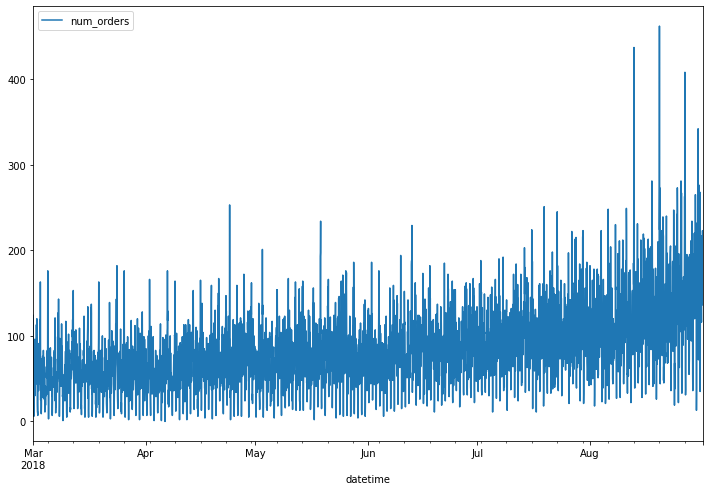

In [6]:
data_taxi = data_taxi.resample('1H').sum()
data_taxi.plot();

Картина стала заметно лучше...по крайней мере визуально.

### Скользящее среднее (размер окна 24)

Чтобы во временном ряду снизить колебания, применим скользящее среднее.

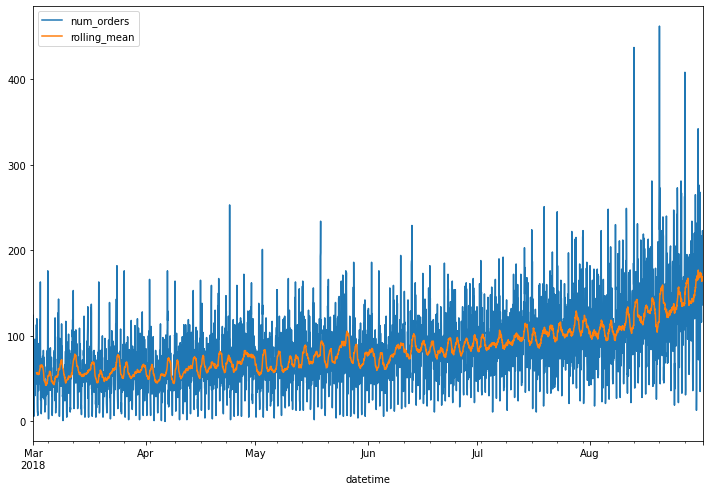

In [7]:
data_taxi_res = data_taxi.copy()
data_taxi_res['rolling_mean'] = data_taxi_res.rolling(24).mean()
data_taxi_res.plot();

Вот теперь другое дело, стало намного лучше.

### Тренды и сезонность

Чтобы лучше понимать временной ряд, разберём тренды и сезонность.

In [8]:
decomposed = seasonal_decompose(data_taxi_res.drop(['rolling_mean'], axis=1))

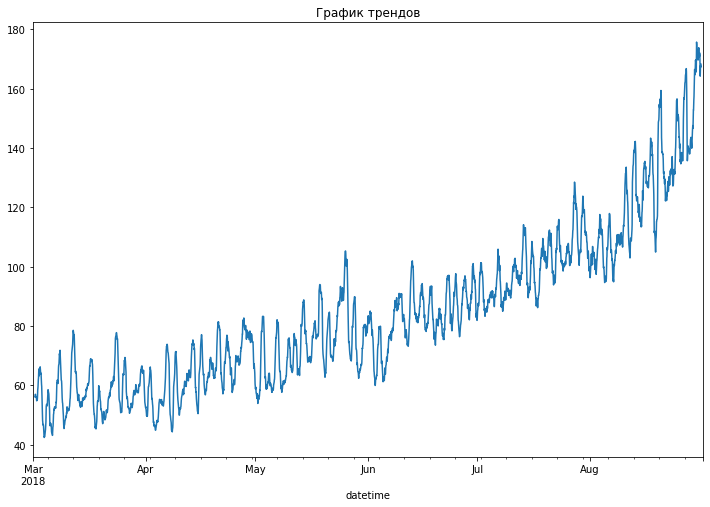

In [9]:
decomposed.trend.plot(ax=plt.gca())
plt.gca().set_title("График трендов");

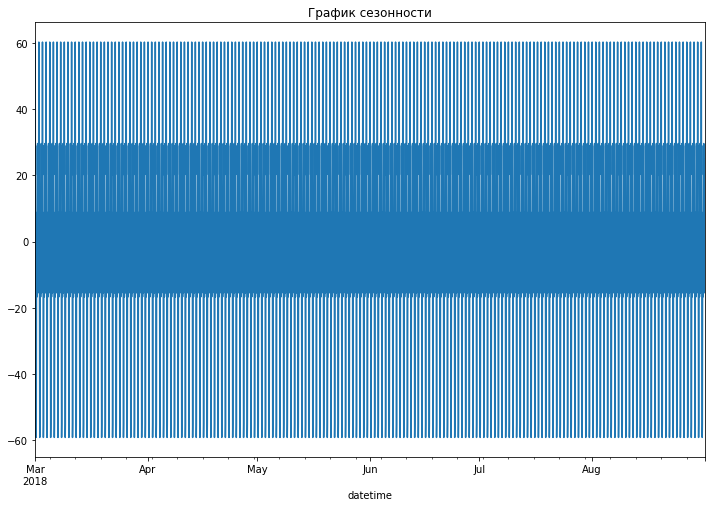

In [10]:
decomposed.seasonal.plot(ax=plt.gca())
plt.gca().set_title("График сезонности");

Так же проверим остаток.

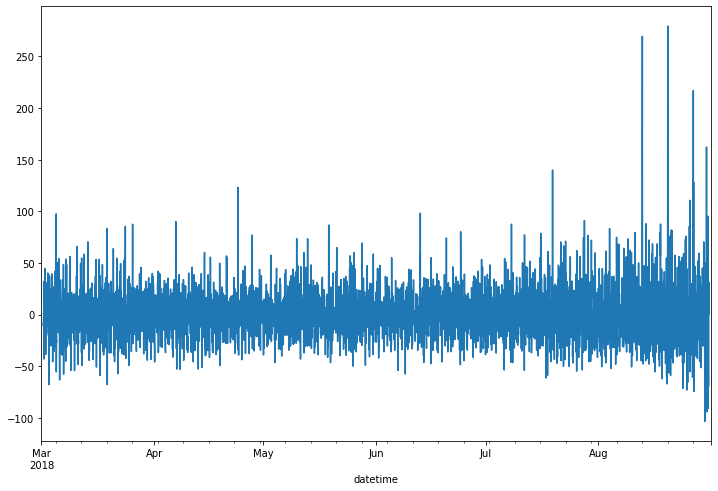

In [11]:
decomposed.resid.plot(ax=plt.gca());

Такие графики не читаемы, поэтому разобьем один большой период на несколько недель и будем делать анализ по такому периоду.

In [12]:
decomposed = seasonal_decompose(data_taxi_res.drop(['rolling_mean'], axis=1)['2018-08-16':'2018-08-31'])

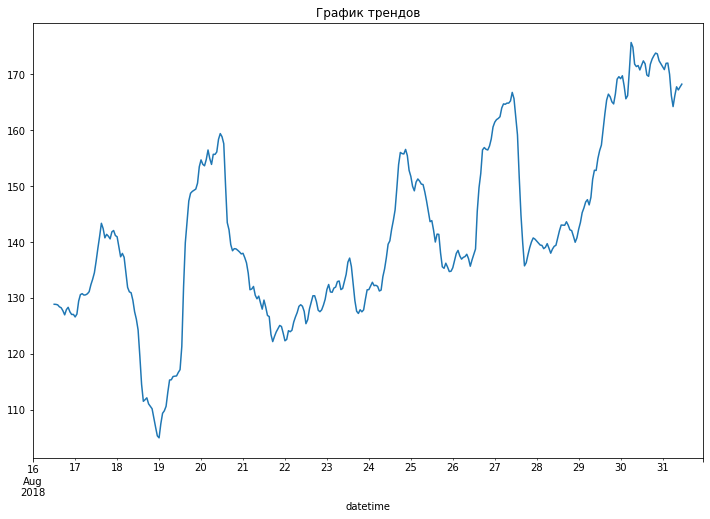

In [13]:
decomposed.trend.plot(ax=plt.gca())
plt.gca().set_title("График трендов");

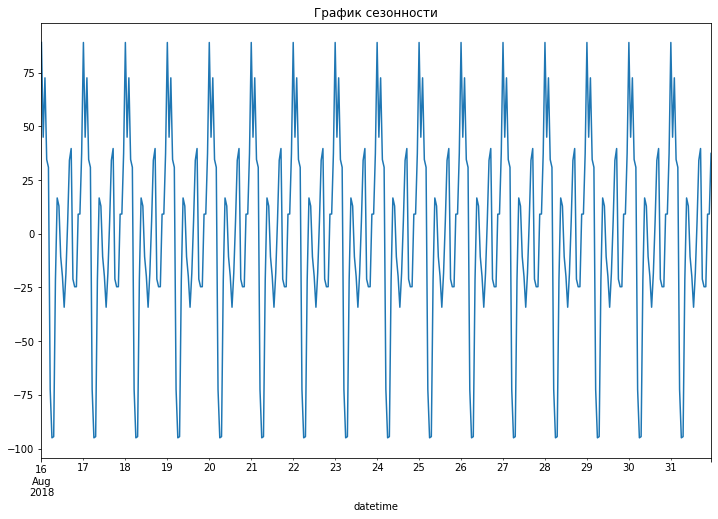

In [14]:
decomposed.seasonal.plot(ax=plt.gca())
plt.gca().set_title("График сезонности");

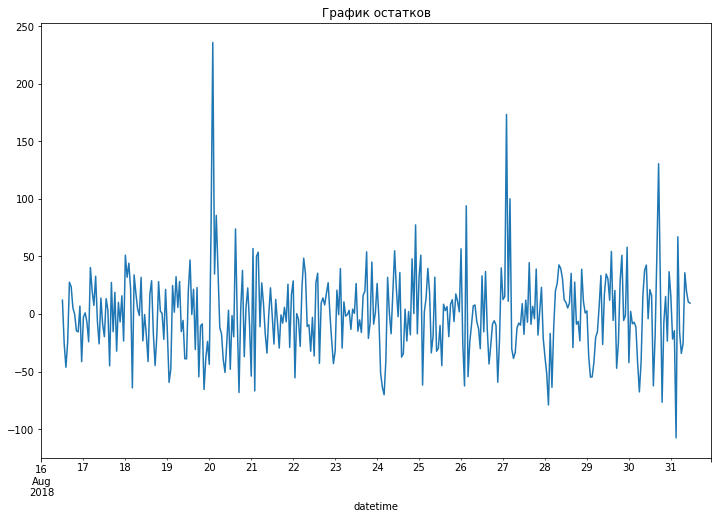

In [15]:
decomposed.resid.plot(ax=plt.gca())
plt.gca().set_title("График остатков");

### Стационарные ряды

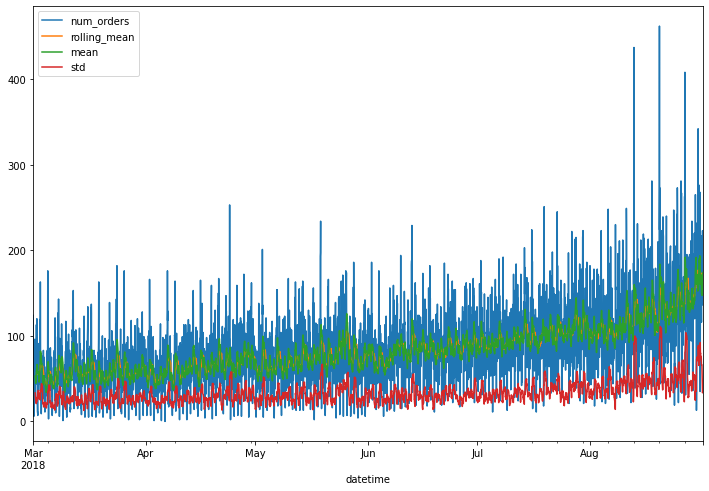

In [16]:
data_taxi_res['mean'] = data_taxi_res['num_orders'].rolling(15).mean()
data_taxi_res['std'] = data_taxi_res['num_orders'].rolling(15).std()
data_taxi_res.plot();

**Вывод:**    
* По тренду видим, что общее количество заказов за это время растет;    
* Так же заметно, что количество заказов по утрам меньше и растет в течение дня;
* Ряд не является стационарным, поскольку его распределение со временем меняется.

## Обучение

### Подготовка данных для обучения, разделение на выборки

In [17]:
def make_features(data, max_lag, rolling_mean_size, column_name='num_orders'):
    """Фукнция для добавления признаков в данные для обучения модели."""
    df = data.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df[column_name].shift(lag)

    df['rolling_mean'] = df[column_name].shift().rolling(rolling_mean_size).mean()
    return df

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b>
        
При генерации новых признаков желательно написать функцию, чтобы она возвращала новый датафрейм, а не изменяла глобальную переменную.
        
1. Это хорошая практика (не изменять глобальные переменные внутри функции), которая улучшает читаемость кода.
2. В какой-то момент может появиться необходимость подбирать некоторые параметры используемые внутри функции. В этот момент копирование датасета станет обязательным.

        
        
        
Для этого внутри, в начале функции нужно задать новое имя датафрейму с `df.copy()`, в нем создать новые признаки, а в конце функции возвращать через `return` этот датафрейм
</div>

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

Понял, переделано.
</div>

Создадим копию исходного датафрейма и добавим в него необходимые признаки.

In [18]:
MAX_LAG = 24
ROLLING_MEAN_SIZE = 48
RANDOM_STATE = 4221
COLUMN_NAME = 'num_orders'

In [19]:
df_learning = make_features(
    data=data_taxi,
    max_lag=MAX_LAG,
    rolling_mean_size=ROLLING_MEAN_SIZE
)
train, test = train_test_split(df_learning, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
train = train.dropna()

features_train = train.drop([COLUMN_NAME], axis=1)
target_train = train[COLUMN_NAME]

features_test = test.drop([COLUMN_NAME], axis=1)
target_test = test[COLUMN_NAME]


Про количество моделей и их типе в проекте указаний нет, поэтому возьму по классике три модели линейной регрессии, дерева и модель градиентного бустинга из предыдущего проекта.

### Масштабирование признаков

In [20]:
num_col_names = features_train.select_dtypes(exclude=['object']).columns.to_list()
print('num_col_names =', num_col_names)

num_col_names = ['month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_mean']


In [21]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(features_train[num_col_names])
test_scaled = scaler.transform(features_test[num_col_names])

train_scaled = pd.DataFrame(train_scaled, columns=num_col_names)
test_scaled = pd.DataFrame(test_scaled, columns=num_col_names)

В дополнение после ревью, создадим объект перекрестной порверки временных рядов.

In [22]:
tscv = TimeSeriesSplit()

### LinearRegression

In [23]:
%%time

lmodel = LinearRegression()
param_grid = {'n_jobs': [-1]}

gs_lmodel = GridSearchCV(lmodel, param_grid, scoring='neg_mean_squared_error', cv=tscv)
gs_lmodel.fit(train_scaled, target_train)

rmse_lmodel = ((gs_lmodel.best_score_)*-1)**0.5
print('RMSE на кросс-валидации для Линейной модели', rmse_lmodel)

RMSE на кросс-валидации для Линейной модели 27.32143567353269
CPU times: user 468 ms, sys: 458 ms, total: 926 ms
Wall time: 902 ms


**Вывод:**    
Обучение модели линейной регрессии выполняется достаточно быстро, а результат по метрике соотвествует требованиям заказчика.

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b>
    
При работе с временными рядами не следует использовать стандартную кросс-валидацию, так как в определенный момент тренировочная выборка окажется позже валидационной. Для решения этой проблемы стоит использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html">TimeSeriesSplit</a>. Объект этого типа нужно передать в параметр cv в метод основанный на кросс-валидации
    
(это касается абсолютно всех моделей, всех cross_val_score и всех SearchCV)
</div>

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

Спасибо, добавил!
</div>

### DecisionTreeRegressor

In [24]:
%%time

DTRmodel = DecisionTreeRegressor(random_state=RANDOM_STATE)
param_grid = {
    'max_depth': list(range(2, 10)),
    'min_samples_split': list(range(2, 10))
}

dtr_lmodel = GridSearchCV(DTRmodel, param_grid, scoring='neg_mean_squared_error', cv=tscv)
dtr_lmodel.fit(train_scaled, target_train)
print(dtr_lmodel.best_params_)

rmse_dtr_lmodel = ((dtr_lmodel.best_score_)*-1)**0.5
print('RMSE на кросс-валидации для Дерева решений', rmse_dtr_lmodel)

{'max_depth': 5, 'min_samples_split': 2}
RMSE на кросс-валидации для Дерева решений 30.927623033690587
CPU times: user 7.57 s, sys: 28.3 ms, total: 7.6 s
Wall time: 7.68 s


**Вывод:**    
Обучение модели дерева решений выполняется немного дольше линейной регресси с учетом перебора гиперпараметров, а результат по метрике соотвествует требованиям заказчика.

### LGBMRegressor

In [25]:
%%time

lgbm_model = LGBMRegressor(random_state=RANDOM_STATE)
params = [{
    'num_leaves':[50, 100], 
    'learning_rate':[0.1, 0.3]}]

lgbm = GridSearchCV(lgbm_model, params, scoring='neg_mean_squared_error', cv=tscv)
lgbm.fit(train_scaled, target_train)
print(lgbm.best_params_)

rmse_lgbm = ((lgbm.best_score_)*-1)**0.5
print('RMSE на кросс-валидации для бустинга', rmse_lgbm)

{'learning_rate': 0.1, 'num_leaves': 50}
RMSE на кросс-валидации для бустинга 26.07115206011196
CPU times: user 1min 7s, sys: 566 ms, total: 1min 7s
Wall time: 1min 8s


**Вывод:**    
Обучение модели бустинга выполняется медленне всех, но результат по метрике так же соотвествует требованиям заказчика и превосходит метрику прочих моделей.

### Анализ моделей

In [26]:
results = pd.DataFrame({
    'Название модели': ['LinearRegression', 'DecisionTreeRegressor', 'LGBMRegressor'],
    'Метрика RMSE': [rmse_lmodel, rmse_dtr_lmodel, rmse_lgbm],
    'Перебор параметров': [False, True, True],
    'Метрика отвечает требования заказчика': [
        'Нет' if rmse_lmodel > 48 else 'Да',
        'Нет' if rmse_dtr_lmodel > 48 else 'Да',
        'Нет' if rmse_lgbm > 48 else 'Да',
    ]
})
results

,Название модели,Метрика RMSE,Перебор параметров,Метрика отвечает требования заказчика
0,LinearRegression,27.321436,False,Да
1,DecisionTreeRegressor,30.927623,True,Да
2,LGBMRegressor,26.071152,True,Да


**Вывод:**    
Все три модели соответствуют требованиям заказчика. Самая лучшая модель с бустингом.

## Тестирование

Определим метрику на тестовой выборке.

In [27]:
better_lgbm = lgbm.best_estimator_

lgbm_predict_test = better_lgbm.predict(test_scaled)
rmse_lgbm_test = root_mean_squared_error(target_test, lgbm_predict_test)
print("RMSE DummyRegressor на тестовой выборке =", round(rmse_lgbm_test, 2))

RMSE DummyRegressor на тестовой выборке = 42.76


Проверим модель на адекватность. Насколько она предсказывает лучше чем DummyRegressor.

In [28]:
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(train_scaled, target_train)
y_predict_dummy_mean = lm_dummy_mean.predict(features_test)
rmse_dum_model = root_mean_squared_error(target_test, y_predict_dummy_mean)
print("RMSE DummyRegressor =", round(rmse_dum_model, 2))

RMSE DummyRegressor = 84.58


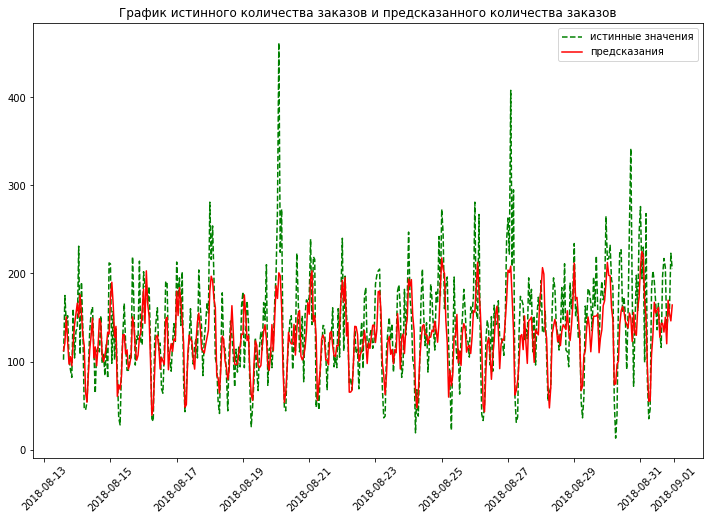

In [29]:
plt.plot(target_test.index, 
         target_test, 
         '--g', 
         target_test.index, 
         lgbm_predict_test,
         'r-')
plt.xticks(rotation=45)
plt.legend(['истинные значения', 'предсказания'])
plt.gca().set_title("График истинного количества заказов и предсказанного количества заказов");

**Вывод:**
Предсказания всех моделей соотвествовало метрике заказчика. В качестве основной модели была выбрана модель с лучшей метрикой среди всех(бустинг). По визуализации предсказаний так же заметно, что модель бустинга недостаточно точно предсказыает пики значений, но при этом достаточно качество выполняет предсказания в целом.

<div class="alert alert-success">   
    
#### 📖 **Полезные ссылки**

* [Полезная лекция про временные ряды](https://www.youtube.com/watch?v=u433nrxdf5k)
* [Б.Б. Демешев - временные ряды](https://disk.yandex.ru/i/LiDHB-B3A6Lz5A)
* [Базовое применение ARIMA](https://colab.research.google.com/drive/17RnG91Eq8JBKyxToNzvCvjibfxum-oPj?usp=sharing)
* [Канторович - Анализ временных рядов](https://yadi.sk/i/IOkUOS3hTXf3gg)
* [По теме выше](https://facebook.github.io/prophet/)
* [Ссылка раз](https://facebook.github.io/prophet/docs/quick_start.html#python-api)
* [Ссылка два](https://nbviewer.jupyter.org/github/miptgirl/habra_materials/blob/master/prophet/habra_data.ipynb)


</div>